<a href="https://colab.research.google.com/github/SanyaMathur0411/CT-practice-set1/blob/main/GAN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network

This notebook demonstrates how to generate images of handwritten digits using a Deep Convolutional Generative Adversarial Network DCGAN.

## What are GANs?

Generative Adversial Network

*  A deep learning architecture
*  It trains two neural networks to compete against each other to generate more authentic new data from a given training dataset.
*   Can be used to generate new results from the existing ones .




![A diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

*   I would visualize the GAN as a *simple divide and rule game*. It trains two different networks and pits them against each other.




*   On *team A* we have the *Generator* which creates new data from the existing data set given to it by modifying it as much as possible however on *team B* we have a *discriminator* which tries to predict whether the generated data output belongs to the original set. So it tries and determines whether the set of data is real or fake until it no longer can differentiate.
*   So this game between team A which constantly tries to generate data closer to the original and team B which tries to detect the fake from original data , we benefit in training these models to generate.   








![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

This notebook is an attempt to  demonstrate this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)



# Setup

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.17.1'

In [ ]:
# To generate GIFs
!pip install imageio #for gifs
!pip install git+https://github.com/tensorflow/docs #visualization tools

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-xxy3f995
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-xxy3f995
  Resolved https://github.com/tensorflow/docs to commit c221d1e1af1ef5cc37c4a0879876f25f9cc1d981
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.11.18.43811-py3-none-any.whl size=182608 sha256=64ed4cb5e6370f4c41594afabfc01558ea835fa3c37677ba976d4ab5c542b967
  Stored in directory: /tmp/pip-ephem-wheel-cache-fuc1jcdg/wheels/34/53/89/3db54cf97ce0f0261aaab3fdc12a847ea0879d34edf373e2c5
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers #used to define architectures of the model , bilding blocks of neural networks
import time

from IPython import display

### Loading and preparing the dataset

Using the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

MNIST data : A collection of grayscale images of handwritten digits (0-9) and their correspoding labels

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


###tf.keras.datasets.mnist.load_data()
This function downloads and loads the MNIST dataset, returning it as two tuples:



*  (train_images, train_labels): The training dataset.
*   (test_images, test_labels): The test dataset






In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')#Each image is reshaped into a 3D format: 28 × 28 (height × width) with 1 channel for grayscale images.
train_images = (train_images - 127.5) / 127.5  # Normalizes the images to [-1, 1], GANs perform better when the input data is normalized to this range.


In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

###*BUFFER_SIZE = 60000*


Shuffling (BUFFER_SIZE = 60,000):


*  Prevents the model from learning patterns due to data order.
*   Matches the MNIST dataset size to fully shuffle all images.

*  TensorFlow randomly selects samples from the shuffle buffer during batching.
*   Larger buffer = more thorough randomization.

*   Smaller buffer = partial shuffling


####*BATCH_SIZE = 256*


Batching (BATCH_SIZE = 256):

*   Processes data in smaller chunks for memory efficiency.
*   Leverages GPU parallelism efficiently.


*   Fits well in GPU memory.
*  Balances stability and efficiency.










*For the MNIST dataset (60,000 images), with a batch size of 256, the training will consist of:*

Steps per Epoch
=
Total Images/
Batch Size

       =60000/256≈234 steps per epoch.



In [ ]:
# Batching and shuffling the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()#loading data

#Creating the models

Both the generator and discriminator are defined using the Keras Sequential API

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Starting with a `Dense` layer that takes this seed as input, upsampling several times until I reach the desired image size of 28x28x1.  `tf.keras.layers.LeakyReLU` is activated for each layer, except the output layer which uses tanh.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    # Projects the 100-dimensional input into a 7x7x256 feature map
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())  # Stabilizes training by normalizing the activations
    model.add(layers.LeakyReLU())  # Adds non-linearity to allow the model to learn complex patterns

    # Reshapes the flat output into a 3D tensor with shape (7, 7, 256)
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Confirms that the shape matches expectations

    # Adds the first transposed convolution to refine features and keep the size (7x7)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())  # Normalizes the activations after the convolution
    model.add(layers.LeakyReLU())  # Adds non-linearity again

    # Adds the second transposed convolution to upsample the image to 14x14
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())  # Normalizes the activations after upsampling
    model.add(layers.LeakyReLU())  # Adds non-linearity for better learning

    # Adds the final transposed convolution to upsample the image to 28x28
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)  # Confirms the final output matches MNIST image size

    return model

Using the (as yet untrained) generator to create an image.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


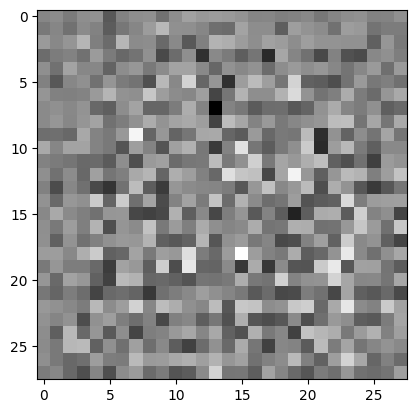

In [ ]:
# Creates the generator model
generator = make_generator_model()

# Generates random noise as input to the generator
# Noise shape: [1, 100] (1 sample of 100-dimensional random values)
noise = tf.random.normal([1, 100])

# Passes the noise through the generator to create a synthetic image
# The 'training=False' argument ensures that layers like BatchNormalization behave appropriately for inference
generated_image = generator(noise, training=False)

# Displays the generated image
# The slicing [0, :, :, 0] selects the first sample and removes the channel dimension for grayscale display
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Adds the first convolutional layer
    # Input: 28x28x1 (grayscale image), Output: feature map of shape (14x14x64)
    # Strides of (2, 2) downsample the image by half
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())  # Adds non-linearity to the features
    model.add(layers.Dropout(0.3))  # Randomly drops 30% of neurons to prevent overfitting

    # Adds the second convolutional layer
    # Input: (14x14x64), Output: (7x7x128) after downsampling
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())  # Adds non-linearity
    model.add(layers.Dropout(0.3))  # Applies dropout to prevent overfitting

    # Flattens the feature maps into a 1D vector for classification
    model.add(layers.Flatten())

    # Adds a dense layer with a single output
    # Output: A scalar value representing whether the input is real (1) or fake (0)
    model.add(layers.Dense(1))

    return model

Using the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
# Creates the discriminator model
discriminator = make_discriminator_model()

# Passes the generated image (from the generator) through the discriminator
# The discriminator evaluates whether the image is real (from the dataset) or fake (from the generator)
decision = discriminator(generated_image)

# Prints the discriminator's output
# This is a scalar value; typically, a higher value indicates the image is real,
# and a lower value indicates the image is fake
print(decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.0012512]], shape=(1, 1), dtype=float32)


# Defining the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    # Computes the loss for real images
    # 'tf.ones_like(real_output)' creates a tensor of ones with the same shape as real_output (real labels)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Computes the loss for fake images
    # 'tf.zeros_like(fake_output)' creates a tensor of zeros with the same shape as fake_output (fake labels)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)


    total_loss = real_loss + fake_loss

    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Thus, comparing the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    # The generator wants the discriminator to classify its generated images as real
    # 'tf.ones_like(fake_output)' creates a tensor of ones with the same shape as fake_output (real labels)
    # The goal is for the discriminator to output values close to 1 (real) for fake images generated by the generator
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since networkes are trained separately.

In [ ]:
# Creates the optimizer for the generator using the Adam optimizer with a learning rate of 1e-4
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Creates the optimizer for the discriminator using the Adam optimizer with a learning rate of 1e-4
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Saving checkpoints
 To save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
# Defines the directory where training checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# Creates a checkpoint prefix by joining the directory path with the checkpoint filename
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Creates a checkpoint object that saves the generator and discriminator models,
# along with their corresponding optimizers
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Defining the training loop


In [ ]:
# Number of training epochs (iterations over the entire dataset)
EPOCHS = 50

# Dimension of the random noise vector (latent space) used as input to the generator
noise_dim = 100

# Number of generated images to visualize at each epoch (for progress tracking)
num_examples_to_generate = 16

# Creating a fixed seed for random noise, which will be reused during training
# This allows consistent generation of images to visualize the model's progress over time
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# The `@tf.function` decorator compiles the `train_step` function into a graph
# for faster execution, improving performance during training.
@tf.function
def train_step(images):
    # Generates random noise (latent vector) for the generator input
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Starts recording gradients for both the generator and discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # Generates fake images from random noise using the generator
        generated_images = generator(noise, training=True)

        # Gets discriminator's output for real images (real_output) and generated images (fake_output)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculates the generator loss (the goal is to trick the discriminator into thinking fake images are real)
        gen_loss = generator_loss(fake_output)

        # Calculates the discriminator loss (the goal is for the discriminator to correctly classify real vs. fake)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculates the gradients for the generator's trainable variables (parameters)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    # Calculates the gradients for the discriminator's trainable variables (parameters)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Applies the gradients to update the generator's weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # Applies the gradients to update the discriminator's weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    # Loop over the number of epochs
    for epoch in range(epochs):
        # Track the start time of each epoch
        start = time.time()

        # Loop through batches of images in the dataset
        for image_batch in dataset:
            # Perform a training step on each batch of images
            train_step(image_batch)

        # Generate and save images after each epoch for visualization (GIF creation)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model checkpoint every 15 epochs to avoid losing progress
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Print the time taken for each epoch
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate and save images after the final epoch to visualize the end result
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

##Generating and saving images


In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Sets `training=False` to ensure the model runs in inference mode,
    # where layers like batch normalization use the learned moving averages.
    predictions = model(test_input, training=False)

    # Creates a figure for displaying the generated images
    fig = plt.figure(figsize=(4, 4))

    # Loops through the generated images and plots them
    for i in range(predictions.shape[0]):
        # Displays each image in a 4x4 grid
        plt.subplot(4, 4, i+1)
        # Rescales the image from [-1, 1] to [0, 255] for proper visualization
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')  # Removes axes for a cleaner output

    # Saves the generated images as a PNG file with the current epoch number in the filename
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()  # Displays the images inline

## Training the model
Calling the `train()` method defined above to train the generator and discriminator simultaneously.

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits look increasingly real. After about 50 epochs, they resemble MNIST digits.

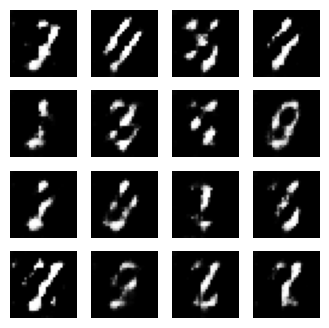

Time for epoch 5 is 716.012113571167 sec


In [ ]:
train(train_dataset, EPOCHS)

Restoring the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Creating a GIF


In [ ]:
# Displays a single image using the epoch number
def display_image(epoch_no):
  # Opens the image file corresponding to the given epoch number
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


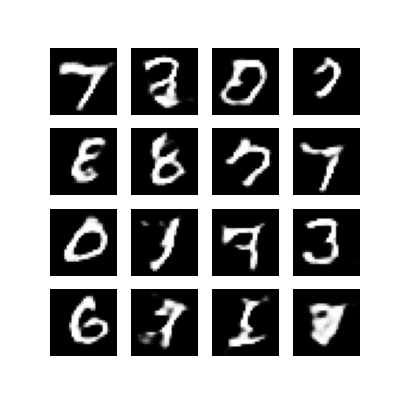

In [ ]:
display_image(EPOCHS)

Using `imageio` to create an animated gif using the images saved during training.

In [ ]:
# Creates an animated GIF of the training progress by compiling images from different epochs
anim_file = 'dcgan.gif'

# Opens a writer to save the GIF using imageio
with imageio.get_writer(anim_file, mode='I') as writer:
    # Gets all filenames starting with 'image' and ending with '.png'
    filenames = glob.glob('image*.png')

    # Sorts the filenames to ensure they are in the correct order (by epoch number)
    filenames = sorted(filenames)

    # Loops through each image file and add it to the GIF
    for filename in filenames:
        image = imageio.imread(filename)  # Read the image
        writer.append_data(image)  # Append the image to the GIF

    # Adds the last image to create a loop effect
    image = imageio.imread(filename)
    writer.append_data(image)

<ipython-input-29-16db4187bea5>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)  # Read the image
<ipython-input-29-16db4187bea5>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



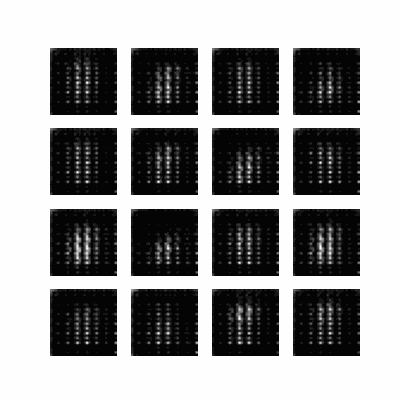

In [ ]:
# Imports the embed utility from TensorFlow documentation for visualizations
import tensorflow_docs.vis.embed as embed

# Embeds the GIF file and displays it inline in the notebook
embed.embed_file(anim_file)